In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import gc
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

# Prepare data

In [2]:
dtypes = {
    'ip'            : 'uint32',
    'app'           : 'uint16',
    'device'        : 'uint16',
    'os'            : 'uint16',
    'channel'       : 'uint16',
    'is_attributed' : 'uint8',
    'click_id'      : 'uint32'
}

In [3]:
train_usecols = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']

In [4]:
%%time
train = pd.read_csv('../data/train.csv', dtype=dtypes, usecols=train_usecols)

CPU times: user 1min 6s, sys: 3.37 s, total: 1min 9s
Wall time: 1min 11s


In [5]:
train.loc[:, 'click_time'] = pd.to_datetime(train.click_time, format='%Y-%m-%d %H:%M:%S')

In [6]:
%%time
train.loc[:, 'date'] = train.click_time.dt.date

CPU times: user 4min 35s, sys: 12.8 s, total: 4min 48s
Wall time: 7min 43s


In [7]:
train.loc[:, 'minute'] = train.click_time.dt.hour * 60 + train.click_time.dt.minute

In [8]:
%%time
train.drop('click_time', axis=1, inplace=True)

CPU times: user 7.95 s, sys: 6.34 s, total: 14.3 s
Wall time: 22.7 s


In [9]:
gc.collect()

21

In [12]:
train = train.loc[(train.click_time >= '2017-11-07 00:00:00') & (train.click_time < '2017-11-09 00:00:00')].copy()

In [10]:
train_gp_idm = train.groupby(['ip', 'date', 'minute'])

In [11]:
def get_sum(group_obj, col):
    res = group_obj[col].nunique()
    res.name = col + 's'
    return res

In [12]:
def get_entropy(group_obj, col):
    values = group_obj[col].value_counts(normalize=True)
    values_log = pd.Series(np.log(values), index=values.index)
    entropy_prep = - values * values_log
    entropy = entropy_prep.groupby(level=[0, 1, 2]).sum()
    entropy.name = col + '_ent'
    return entropy

In [13]:
def create_feats(group_obj, feats=['app', 'device', 'os', 'channel']):
    print('clicks ...')
    clicks = group_obj.size()
    clicks.name = 'clicks'
    print('others ...')
    series = [clicks]
    for feat in feats:
        series.append(get_sum(group_obj, feat))
        series.append(get_entropy(group_obj, feat))
    return pd.concat(series, axis=1)

In [14]:
%%time
train_feats = create_feats(train_gp_idm)

clicks ...
others ...
CPU times: user 12min 27s, sys: 1min 8s, total: 13min 36s
Wall time: 13min 47s


In [15]:
train_feats.head()

clicks  apps   app_ent  devices  device_ent  oss  \
ip date       minute                                                     
1  2017-11-08 1045         4     4  1.386294        1         0.0    1   
              1067         1     1  0.000000        1         0.0    1   
              1177         1     1  0.000000        1         0.0    1   
              1199         1     1  0.000000        1         0.0    1   
              1205         1     1  0.000000        1         0.0    1   

                      os_ent  channels  channel_ent  
ip date       minute                                 
1  2017-11-08 1045       0.0         3     1.039721  
              1067       0.0         1     0.000000  
              1177       0.0         1     0.000000  
              1199       0.0         1     0.000000  
              1205       0.0         1     0.000000

In [19]:
%who

create_feats	 dtypes	 gc	 get_entropy	 get_sum	 lgb	 np	 pd	 train	 
train1	 train_feats	 train_gp_idm	 train_usecols	 


In [16]:
del train_gp_idm
gc.collect()

48

In [17]:
%%time
train = pd.merge(train, train_feats, left_on=['ip', 'date', 'minute'], right_index=True, how='left')

CPU times: user 1min 57s, sys: 1min 22s, total: 3min 20s
Wall time: 1h 8min 7s


In [18]:
train.head()

,ip,app,device,os,channel,is_attributed,date,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent
0,83230,3,1,13,379,0,2017-11-06,872,1,1,0.0,1,0.0,1,0.0,1,0.0
1,17357,3,1,19,379,0,2017-11-06,873,1,1,0.0,1,0.0,1,0.0,1,0.0
2,35810,3,1,13,379,0,2017-11-06,874,1,1,0.0,1,0.0,1,0.0,1,0.0
3,45745,14,1,13,478,0,2017-11-06,874,1,1,0.0,1,0.0,1,0.0,1,0.0
4,161007,3,1,13,379,0,2017-11-06,875,1,1,0.0,1,0.0,1,0.0,1,0.0


In [19]:
del train_feats
gc.collect()

126

In [24]:
valid = train.loc[train.click_time >= '2017-11-08 00:00:00'].copy()
train = train.loc[train.click_time < '2017-11-08 00:00:00'].copy()

In [21]:
train.drop(['ip', 'date'], axis=1, inplace=True)

In [25]:
valid.drop(['ip', 'click_time', 'date'], axis=1, inplace=True)

In [22]:
gc.collect()

0

In [23]:
train.head()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent
0,3,1,13,379,0,872,1,1,0.0,1,0.0,1,0.0,1,0.0
1,3,1,19,379,0,873,1,1,0.0,1,0.0,1,0.0,1,0.0
2,3,1,13,379,0,874,1,1,0.0,1,0.0,1,0.0,1,0.0
3,14,1,13,478,0,874,1,1,0.0,1,0.0,1,0.0,1,0.0
4,3,1,13,379,0,875,1,1,0.0,1,0.0,1,0.0,1,0.0


In [28]:
valid.head()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent
68941878,23,1,13,153,0,0,30,12,2.219121,2,0.146145,7,1.560487,22,2.967867
68941879,13,1,16,477,0,0,13,10,2.245035,1,0.000000,3,0.925129,8,1.991509
68941880,12,1,13,259,0,0,2,2,0.693147,1,0.000000,1,0.000000,2,0.693147
68941881,15,1,19,265,0,0,14,9,2.106577,2,0.257319,3,0.758937,13,2.540036
68941882,6,1,18,125,0,0,12,6,1.583258,1,0.000000,1,0.000000,10,2.253858


In [24]:
%%time
train.to_csv('../derived_data/agg_clicks_train_full.csv', index=False)

CPU times: user 26min 41s, sys: 8.24 s, total: 26min 49s
Wall time: 26min 59s


In [29]:
valid.to_csv('../derived_data/agg_clicks_valid.csv', index=False)

CPU times: user 17min 49s, sys: 5.37 s, total: 17min 54s
Wall time: 18min 8s


In [25]:
post_dtypes = {
    'minute': 'uint16',
    'clicks': 'uint16',
    'apps': 'uint16',
    'devices': 'uint16',
    'oss': 'uint16',
    'channels': 'uint16',
    'app_ent': 'float16',
    'device_ent': 'float16',
    'os_ent': 'float16',
    'channel_ent': 'float16',
}

In [26]:
train = train.astype(post_dtypes)

In [31]:
valid = valid.astype(post_dtypes)

In [32]:
%who

create_feats	 dtypes	 gc	 get_entropy	 get_sum	 lgb	 np	 pd	 post_dtypes	 
train	 train_usecols	 valid	 


In [27]:
gc.collect()

0

In [34]:
%reset Out

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (9 entries)


# Random forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
rfc = RandomForestClassifier(n_estimators=23, n_jobs=4, class_weight={0: 1, 1: 300})

In [85]:
input_features = ['app', 'apps', 'app_ent',
                  'device', 'devices', 'device_ent',
                  'os', 'oss', 'os_ent',
                  'channel', 'channels', 'channel_ent',
                  'minute', 'clicks']
input_features = ['app', 'channel', 'minute']
label = 'is_attributed'

In [38]:
train.shape

(59632496, 15)

In [39]:
valid.shape

(62945075, 15)

In [86]:
%%time
rfc.fit(train.loc[:, input_features], train.loc[:, label])

CPU times: user 45min 6s, sys: 1min, total: 46min 7s
Wall time: 12min 37s


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 300},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=23, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [87]:
pred_prob = rfc.predict_proba(valid.loc[:, input_features])[:, 1]

In [88]:
pred = (pred_prob > 0.5).astype('uint8')

In [89]:
len(np.unique(pred_prob))

51019

In [90]:
precision_score(valid.loc[:, label], pred)

0.08513816686072923

In [91]:
recall_score(valid.loc[:, label], pred)

0.7163076160473777

In [92]:
roc_auc_score(valid.loc[:, label], pred_prob)

0.8789456476967574

In [93]:
valid.loc[:, 'pred'] = pred
valid.loc[:, 'pred_prob'] = pred_prob

In [62]:
valid.loc[(valid.pred_prob > .99) & (valid.is_attributed == 1)].head()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
68945925,35,1,18,274,1,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,1.000000
68964705,35,1,19,274,1,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,1.000000
68971329,19,0,21,213,1,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998281
68985910,35,1,18,274,1,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,1.000000
68987188,19,0,21,213,1,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998281


In [63]:
valid.loc[(valid.pred_prob > .99) & (valid.is_attributed == 1)].tail()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
131774766,35,1,13,274,1,1437,1,1,0.0,1,0.0,1,0.0,1,0.0,1,1.000
131782159,35,1,13,274,1,1437,1,1,0.0,1,0.0,1,0.0,1,0.0,1,1.000
131810723,19,0,29,213,1,1438,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998
131844428,35,1,16,274,1,1439,1,1,0.0,1,0.0,1,0.0,1,0.0,1,1.000
131861612,35,1,15,274,1,1439,1,1,0.0,1,0.0,1,0.0,1,0.0,1,1.000


In [64]:
valid.loc[(valid.pred_prob < .01) & (valid.is_attributed == 0)].head()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
68941878,23,1,13,153,0,0,30,12,2.218750,2,0.146118,7,1.560547,22,2.968750,0,0.0
68941879,13,1,16,477,0,0,13,10,2.244141,1,0.000000,3,0.925293,8,1.991211,0,0.0
68941880,12,1,13,259,0,0,2,2,0.693359,1,0.000000,1,0.000000,2,0.693359,0,0.0
68941881,15,1,19,265,0,0,14,9,2.107422,2,0.257324,3,0.758789,13,2.539062,0,0.0
68941882,6,1,18,125,0,0,12,6,1.583008,1,0.000000,1,0.000000,10,2.253906,0,0.0


In [65]:
valid.loc[(valid.pred_prob < .01) & (valid.is_attributed == 0)].tail()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
131886948,27,1,19,122,0,1439,3,3,1.098633,1,0.00000,1,0.000000,3,1.098633,0,0.0
131886949,3,1,17,409,0,1439,1,1,0.000000,1,0.00000,1,0.000000,1,0.000000,0,0.0
131886950,18,1,27,134,0,1439,10,9,2.164062,1,0.00000,1,0.000000,10,2.302734,0,0.0
131886951,15,1,13,245,0,1439,86,20,2.660156,2,0.54248,17,2.158203,39,3.351562,0,0.0
131886952,15,1,16,111,0,1439,6,3,1.011719,1,0.00000,2,0.636719,3,0.867676,0,0.0


In [66]:
valid.loc[(valid.pred_prob < .01) & (valid.is_attributed == 1)].head()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
68943564,18,1,18,121,1,0,6,5,1.560547,1,0.000000,2,0.693359,6,1.791992,0,0.0
68943698,9,1,19,466,1,0,6,6,1.791992,1,0.000000,1,0.000000,5,1.560547,0,0.0
68944635,20,1,19,478,1,0,6,6,1.791992,1,0.000000,1,0.000000,5,1.560547,0,0.0
68945054,19,0,0,213,1,0,22,13,2.324219,2,0.184937,6,1.362305,16,2.666016,0,0.0
68947389,21,1,17,232,1,0,6,5,1.560547,1,0.000000,2,0.450439,5,1.560547,0,0.0


In [68]:
valid.loc[(valid.pred_prob < .01) & (valid.is_attributed == 1)].tail()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
131876853,29,1,13,213,1,1439,1,1,0.000000,1,0.0,1,0.000000,1,0.000000,0,0.0
131883376,15,1,22,245,1,1439,3,3,1.098633,1,0.0,1,0.000000,3,1.098633,0,0.0
131885713,10,1,19,317,1,1439,5,5,1.609375,1,0.0,2,0.672852,4,1.332031,0,0.0
131886032,202,1,13,421,1,1439,21,9,1.976562,1,0.0,6,1.477539,13,2.238281,0,0.0
131886321,29,1,13,210,1,1439,3,3,1.098633,1,0.0,3,1.098633,3,1.098633,0,0.0


In [69]:
valid.loc[(valid.pred_prob > 0.99) & (valid.is_attributed == 0)].head()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
68950470,19,0,21,213,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998281
68962722,19,0,21,213,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998281
68963299,19,0,21,213,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998281
68975987,19,0,21,213,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998281
69223351,35,1,13,21,0,5,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.999304


In [70]:
valid.loc[(valid.pred_prob > 0.99) & (valid.is_attributed == 0)].tail()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
131795248,19,0,24,213,0,1438,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998817
131811746,19,0,24,213,0,1438,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998817
131814354,19,0,24,213,0,1438,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998817
131830649,19,0,29,213,0,1438,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998000
131831680,19,0,29,213,0,1438,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998000


In [71]:
valid.loc[(valid.pred_prob > 0.49) & (valid.pred_prob < 0.51) & (valid.is_attributed == 0)].head()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
68942282,18,1,19,107,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.496396
68943112,18,1,19,107,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.496396
68943511,18,1,19,107,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.496396
68944199,18,1,19,107,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.496396
68944644,18,1,19,107,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.496396


In [72]:
valid.loc[(valid.pred_prob > 0.49) & (valid.pred_prob < 0.51) & (valid.is_attributed == 0)].tail()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
131746501,9,1,13,334,0,1436,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.508632
131746507,9,1,19,334,0,1436,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.508182
131746652,9,1,19,334,0,1436,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.508182
131746763,9,1,19,334,0,1436,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.508182
131747118,9,1,13,334,0,1436,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.508632


In [73]:
valid.loc[(valid.pred_prob > 0.49) & (valid.pred_prob < 0.51) & (valid.is_attributed == 1)].head()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
70917634,9,1,19,244,1,33,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.498986
72365337,9,1,19,334,1,58,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.490900
80870284,3,1,18,280,1,213,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.506169
83927020,9,1,19,244,1,268,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.499243
90419795,19,0,24,213,1,389,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.505132


In [74]:
valid.loc[(valid.pred_prob > 0.49) & (valid.pred_prob < 0.51) & (valid.is_attributed == 1)].tail()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
118961810,19,0,24,213,1,903,1,1,0.000000,1,0.0,1,0.0,1,0.000000,0,0.509614
118972186,19,0,24,213,1,903,1,1,0.000000,1,0.0,1,0.0,1,0.000000,0,0.509614
118978289,19,0,24,213,1,903,1,1,0.000000,1,0.0,1,0.0,1,0.000000,0,0.509614
128766632,24,1,19,105,1,1350,2,2,0.693359,1,0.0,1,0.0,2,0.693359,0,0.491711
131729768,9,1,13,334,1,1436,1,1,0.000000,1,0.0,1,0.0,1,0.000000,0,0.508632


In [94]:
importance = rfc.feature_importances_

In [95]:
importance

array([0.55535909, 0.31572601, 0.1289149 ])

In [96]:
importance_std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

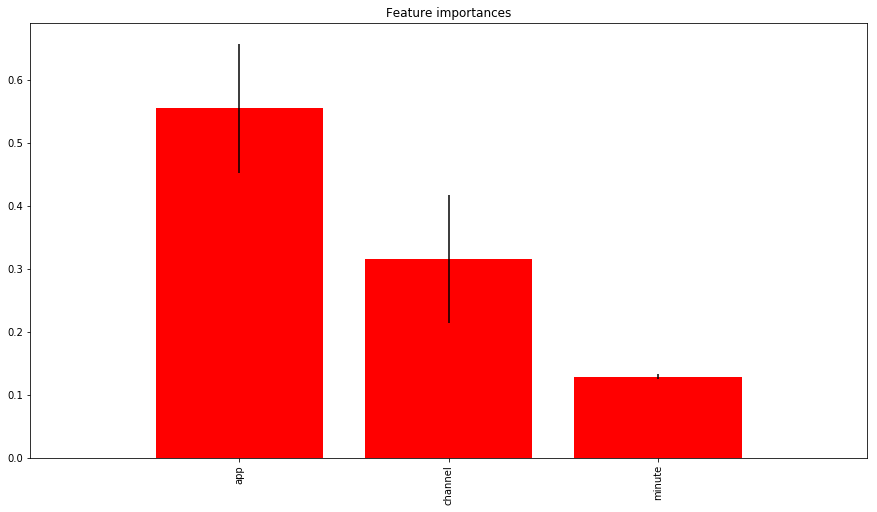

In [97]:
indices = np.argsort(importance)[::-1]
features = [input_features[i] for i in indices]
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.bar(range(train.loc[:, input_features].shape[1]), importance[indices], color="r", yerr=importance_std[indices], align="center")
plt.xticks(range(train.loc[:, input_features].shape[1]), features, rotation=90)
plt.xlim([-1, train.loc[:, input_features].shape[1]])
plt.show()

# Light GBM

In [28]:
predictors = [
    'app', 'apps', 'app_ent',
    'device', 'devices', 'device_ent',
    'os', 'oss', 'os_ent',
    'channel', 'channels', 'channel_ent',
    'minute', 'clicks'
]
target = 'is_attributed'

In [29]:
categorical = ['app', 'device', 'os', 'channel']

In [30]:
gc.collect()

0

In [31]:
params = {
    'boosting_type': 'gbdt',  # I think dart would be better, but takes too long to run
    'drop_rate': 0.1,  # Rate at which to drop trees
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 11,  # Was 255: Reduced to control overfitting
    'max_depth': -1,  # Was 8: LightGBM splits leaf-wise, so control depth via num_leaves
    'min_child_samples': 100,
    'max_bin': 100,
    'subsample': 0.9,  # Was 0.7
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'min_child_weight': 0,
    'subsample_for_bin': 200000,
    'min_split_gain': 0,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'nthread': 8,
    'verbose': 0,
    'scale_pos_weight': 300
}

In [32]:
dtrain = lgb.Dataset(
    train.loc[:, predictors].values,
    label=train.loc[:, target].values,
    feature_name=predictors,
    categorical_feature=categorical
)

In [33]:
del train

In [34]:
gc.collect()

41

In [35]:
cv_results = lgb.cv(
    params=params,
    train_set=dtrain,
    nfold=3,
    num_boost_round=400,
    early_stopping_rounds=30,
    verbose_eval=20,
    categorical_feature=categorical
)

[20]	cv_agg's auc: 0.961205 + 0.000574086
[40]	cv_agg's auc: 0.964798 + 0.000364204
[60]	cv_agg's auc: 0.966918 + 0.000350742
[80]	cv_agg's auc: 0.967962 + 0.000321953
[100]	cv_agg's auc: 0.968634 + 0.000271839
[120]	cv_agg's auc: 0.969067 + 0.000241199
[140]	cv_agg's auc: 0.969436 + 0.00024324
[160]	cv_agg's auc: 0.969693 + 0.000245108
[180]	cv_agg's auc: 0.969899 + 0.000238066
[200]	cv_agg's auc: 0.97006 + 0.000239112
[220]	cv_agg's auc: 0.970197 + 0.000218018
[240]	cv_agg's auc: 0.970309 + 0.000216405
[260]	cv_agg's auc: 0.970417 + 0.000231374
[280]	cv_agg's auc: 0.970503 + 0.000230732
[300]	cv_agg's auc: 0.97057 + 0.000211599
[320]	cv_agg's auc: 0.970632 + 0.000206177
[340]	cv_agg's auc: 0.970698 + 0.000204478
[360]	cv_agg's auc: 0.970749 + 0.000200189
[380]	cv_agg's auc: 0.970793 + 0.000192935
[400]	cv_agg's auc: 0.970842 + 0.000185064


In [36]:
OPT_BOOST_ROUNDS = np.argmax(cv_results['auc-mean'])

In [37]:
lgb_model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=OPT_BOOST_ROUNDS,
    categorical_feature=categorical
)

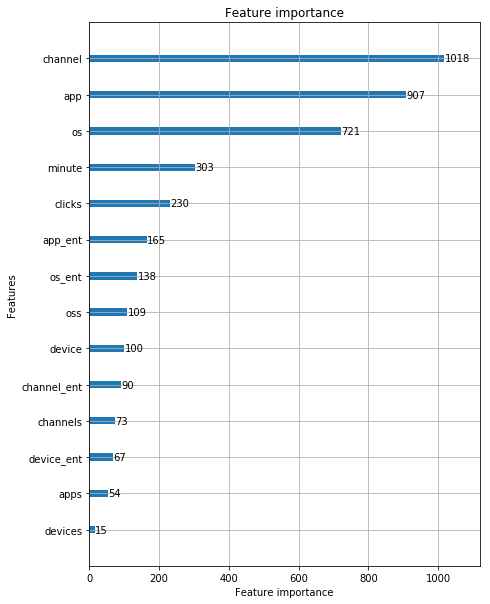

In [38]:
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_model, ax=ax, max_num_features=len(predictors))

In [48]:
pred = lgb_model.predict(valid.loc[:, predictors], num_iteration=lgb_model.best_iteration)

In [49]:
pred.shape

(62945075,)

In [50]:
valid.loc[:, 'pred'] = pred

In [51]:
valid.head()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred
68941878,23,1,13,153,0,0,30,12,2.218750,2,0.146118,7,1.560547,22,2.968750,0.007048
68941879,13,1,16,477,0,0,13,10,2.244141,1,0.000000,3,0.925293,8,1.991211,0.034831
68941880,12,1,13,259,0,0,2,2,0.693359,1,0.000000,1,0.000000,2,0.693359,0.034641
68941881,15,1,19,265,0,0,14,9,2.107422,2,0.257324,3,0.758789,13,2.539062,0.045199
68941882,6,1,18,125,0,0,12,6,1.583008,1,0.000000,1,0.000000,10,2.253906,0.004175


In [52]:
roc_auc_score(valid.loc[:, target], pred)

0.9712002360483499

In [39]:
import pickle

In [40]:
with open('../results/lgm.pickle', 'wb') as f:
    pickle.dump(lgb_model, f)

In [ ]:
dvalid = lgb.Dataset(
    valid.loc[:, predictors].values,
    label=valid.loc[:, target].values,
    feature_name=predictors,
    categorical_feature=categorical
)

In [ ]:
lgb_model = lgb.train(params, 
                 dtrain, 
                 valid_sets=[dtrain, dvalid], 
                 valid_names=['train','valid'], 
                 evals_result=evals_results, 
                 num_boost_round=1000,
                 early_stopping_rounds=30,
                 verbose_eval=50, 
                 feval=None)